https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [1]:
import pandas as pd
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
dates = df['ds'].values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order

In [4]:
# Initiate the model
baseline_model = Prophet()# Fit the model on the training dataset
baseline_model.fit(train)

19:09:55 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] done processing


Create Model

In [5]:
baseline_model_cv = cross_validation(model=baseline_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] done processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] done processing
19:09:56 - cmdstanpy - INFO - Chain [1] sta

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-10-06,230.519776,212.788806,248.432610,246.063004,2015-10-05
1,2015-10-07,230.172571,211.945468,247.660571,242.968994,2015-10-05
2,2015-10-08,230.317331,212.422177,248.374591,242.304001,2015-10-05
3,2015-10-09,230.971187,214.069781,248.098929,243.931000,2015-10-05
4,2015-10-10,229.039412,211.716983,247.345778,244.940994,2015-10-05


Plot the result

In [6]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,9.554355e+07,9774.638135,5646.276499,0.307077,0.240607,0.291767,0.265926


RMSE of the result

In [7]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

0.30707682711236045

In [8]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.9)# Fit the model on the training dataset
manual_model.fit(train)# Cross validation
manual_model_cv = cross_validation(manual_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

19:10:02 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] done processing
19:10:03 - cmdstanpy - INFO - Chain [1] sta

0.2442109644215608

In [9]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] done processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] done processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
19:10:11 - cmdstanpy - INFO - Chain [1] done processing
19:10:

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'seasonality_mode': 'additive'}


In [10]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation


pred = auto_model.predict(test[['ds']])
auto_model_cv = cross_validation(auto_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p

19:22:36 - cmdstanpy - INFO - Chain [1] start processing
19:22:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] done processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] sta

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,3.092629e+07,5561.141274,3062.724003,0.191637,0.146118,0.19008,0.317778


In [11]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-02-26,15381.055546,14407.894346,23072.863912,15381.055546,15381.055546,3529.803699,3529.803699,3529.803699,-7.225645,-7.225645,-7.225645,3537.029344,3537.029344,3537.029344,0.0,0.0,0.0,18910.859245
1,2023-02-27,15330.816951,14543.952134,23217.651194,15330.816951,15330.816951,3516.285853,3516.285853,3516.285853,7.099883,7.099883,7.099883,3509.185970,3509.185970,3509.185970,0.0,0.0,0.0,18847.102804
2,2023-02-28,15280.578357,14550.214832,22875.758778,15280.578357,15280.578357,3462.425561,3462.425561,3462.425561,-13.682988,-13.682988,-13.682988,3476.108548,3476.108548,3476.108548,0.0,0.0,0.0,18743.003918
3,2023-03-01,15230.339762,14455.013601,23097.808329,15230.339762,15230.339762,3464.910595,3464.910595,3464.910595,24.942836,24.942836,24.942836,3439.967759,3439.967759,3439.967759,0.0,0.0,0.0,18695.250357
4,2023-03-02,15180.101168,14040.301323,22879.050299,15180.101168,15180.101168,3383.556677,3383.556677,3383.556677,-19.383268,-19.383268,-19.383268,3402.939945,3402.939945,3402.939945,0.0,0.0,0.0,18563.657845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,2024-01-29,-1549.350756,-52642.489672,48415.052401,-51975.093601,47601.856529,422.613644,422.613644,422.613644,7.099883,7.099883,7.099883,415.513761,415.513761,415.513761,0.0,0.0,0.0,-1126.737112
338,2024-01-30,-1599.589350,-52433.830810,49055.187697,-52343.783975,47777.478804,479.142345,479.142345,479.142345,-13.682988,-13.682988,-13.682988,492.825333,492.825333,492.825333,0.0,0.0,0.0,-1120.447005
339,2024-01-31,-1649.827945,-53686.575576,48434.470052,-52697.545945,47945.006502,612.764706,612.764706,612.764706,24.942836,24.942836,24.942836,587.821870,587.821870,587.821870,0.0,0.0,0.0,-1037.063238
340,2024-02-01,-1700.066539,-52367.424610,48896.958135,-53049.776894,48054.881624,680.365452,680.365452,680.365452,-19.383268,-19.383268,-19.383268,699.748720,699.748720,699.748720,0.0,0.0,0.0,-1019.701087


In [12]:
from metrics import print_evaluation_metrics
non_zero = []
import sys
 
for i in pred['yhat']:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 743910741.06
RMSE: 27274.73
MAE: 24768.10
MAPE: 75.77
SMAPE: 132.89


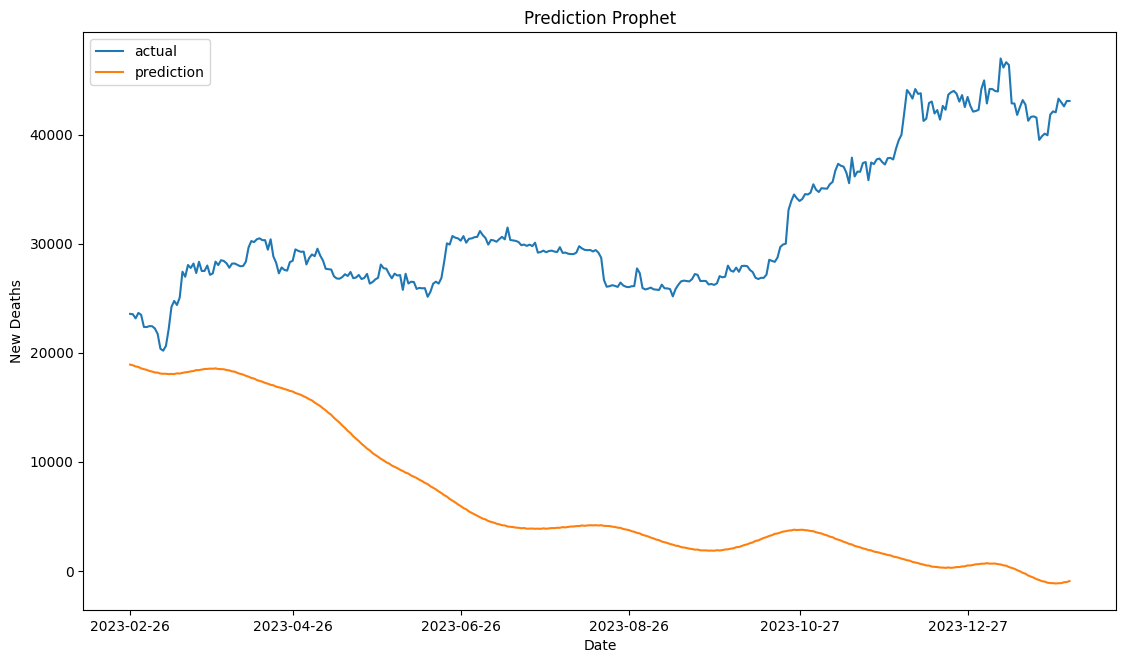

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred['yhat'], label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [14]:
# Create a copy of the data
data_log = df.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})
data_log.head()

,ds,floor,y
0,2014-09-24,0,6.047857
1,2014-09-25,0,6.019989
2,2014-09-26,0,6.002466
3,2014-09-27,0,5.990264
4,2014-09-28,0,5.932725


In [15]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)
auto_model_log_p

19:23:03 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.415887  0.644893  0.524916  0.058738  0.049433  0.057472   

   coverage  
0  0.466007  


19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:23:13 - cmdstanpy - INFO - Chain [1] start processing
19:23:13 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] start

  horizon      mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.46126  0.679162  0.555102  0.062226  0.054145  0.06081  0.450825


19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start p

  horizon       mse      rmse     mae      mape     mdape     smape  coverage
0 30 days  0.419853  0.647961  0.5277  0.059222  0.050919  0.057942  0.455116


19:23:31 - cmdstanpy - INFO - Chain [1] start processing
19:23:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start

  horizon       mse     rmse       mae     mape     mdape     smape  coverage
0 30 days  0.467788  0.68395  0.557755  0.06255  0.053055  0.061165  0.445215


19:23:41 - cmdstanpy - INFO - Chain [1] start processing
19:23:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] done processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] done processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] done processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse     mae      mape     mdape     smape  coverage
0 30 days  0.419794  0.647915  0.5278  0.059248  0.050645  0.057974  0.456436


19:23:50 - cmdstanpy - INFO - Chain [1] start processing
19:23:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing
19:23:52 - cmdstanpy - INFO - Chain [1] start processing
19:23:52 - cmdstanpy - INFO - Chain [1] done processing
19:23:52 - cmdstanpy - INFO - Chain [1] done processing
19:23:52 - cmdstanpy - INFO - Chain [1] start processing
19:23:52 - cmdstanpy - INFO - Chain [1] start processing
19:23:52 - cmdstanpy - INFO - Chain [1] done processing
19:23:52 - cmdstanpy - INFO - Chain [1] done processing
19:23:52 - cmdstanpy - INFO - Chain [1] done processing
19:23:52 - cmdstanpy - INFO - Chain [1] start processing
19:23:52 - cmdstanpy - INFO - Chain [1] start pr

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.468001  0.684106  0.559128  0.062689  0.053216  0.061293   

   coverage  
0  0.443234  


19:23:58 - cmdstanpy - INFO - Chain [1] start processing
19:23:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:23:59 - cmdstanpy - INFO - Chain [1] start processing
19:23:59 - cmdstanpy - INFO - Chain [1] start processing
19:23:59 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] start pr

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.417113  0.645843  0.525274  0.05896  0.050714  0.057677  0.457096


19:24:07 - cmdstanpy - INFO - Chain [1] start processing
19:24:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] done processing
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] done processing
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.467121  0.683463  0.559196  0.062638  0.053316  0.061225   

   coverage  
0  0.443234  


19:24:16 - cmdstanpy - INFO - Chain [1] start processing
19:24:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] done processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] done processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.417644  0.646254  0.52551  0.058994  0.050971  0.057709  0.459406


19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] done processing
19:24:28 - cmdstanpy - INFO - Chain [1] done processing
19:24:28 - cmdstanpy - INFO - Chain [1] done processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.471201  0.686441  0.561957  0.062981  0.053426  0.061582   

   coverage  
0  0.446205  


19:24:36 - cmdstanpy - INFO - Chain [1] start processing
19:24:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] done processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.151652  0.389426  0.308741  0.032768  0.029276  0.03277  0.245215


19:25:07 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] done processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] done processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] done processing
19:25:12 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.162366  0.402946  0.316971  0.033695  0.030721  0.033685   

   coverage  
0  0.249505  


19:25:41 - cmdstanpy - INFO - Chain [1] start processing
19:25:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.152237  0.390175  0.309872  0.03294  0.029619  0.032941  0.237954


19:26:14 - cmdstanpy - INFO - Chain [1] start processing
19:26:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] done processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] done processing
19:26:18 - cmdstanpy - INFO - Chain [1] done processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163654  0.404542  0.319224  0.034021  0.031009  0.034018   

   coverage  
0  0.240264  


19:26:47 - cmdstanpy - INFO - Chain [1] start processing
19:26:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] done processing
19:26:52 - cmdstanpy - INFO - Chain [1] done processing
19:26:52 - cmdstanpy - INFO - Chain [1] done processing
19:26:52 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.151857  0.389688  0.309668  0.032944  0.029616  0.032948   

   coverage  
0  0.241254  


19:27:22 - cmdstanpy - INFO - Chain [1] start processing
19:27:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] done processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163464  0.404306  0.319447  0.034043  0.030842  0.034031   

   coverage  
0  0.231353  


19:27:55 - cmdstanpy - INFO - Chain [1] start processing
19:27:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] done processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] don

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.152032  0.389913  0.310035  0.03298  0.029666  0.032981  0.236304


19:28:24 - cmdstanpy - INFO - Chain [1] start processing
19:28:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] done processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163478  0.404324  0.318837  0.033972  0.030882  0.033959   

   coverage  
0  0.237294  


19:28:55 - cmdstanpy - INFO - Chain [1] start processing
19:28:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:28:59 - cmdstanpy - INFO - Chain [1] start processing
19:28:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] done processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] done processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.151805  0.389622  0.30977  0.032959  0.029643  0.032957  0.234653


19:29:28 - cmdstanpy - INFO - Chain [1] start processing
19:29:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:29:31 - cmdstanpy - INFO - Chain [1] start processing
19:29:31 - cmdstanpy - INFO - Chain [1] start processing
19:29:31 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163396  0.404223  0.318654  0.033935  0.030744  0.033929   

   coverage  
0  0.238614  


19:30:00 - cmdstanpy - INFO - Chain [1] start processing
19:30:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] done processing
19:30:05 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] done processing
19:30:05 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.149743  0.386966  0.304443  0.032283  0.02936  0.032274  0.254125


19:30:34 - cmdstanpy - INFO - Chain [1] start processing
19:30:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] done processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.160263  0.400329  0.312479  0.033147  0.029474  0.033129   

   coverage  
0  0.240264  


19:31:00 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] start processing
19:31:04 - cmdstanpy - INFO - Chain [1] do

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.151578  0.38933  0.307617  0.032724  0.030324  0.032713  0.253465


19:31:27 - cmdstanpy - INFO - Chain [1] start processing
19:31:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] done processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] done processing
19:31:30 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.162321  0.402891  0.315438  0.03361  0.030492  0.033587  0.248185


19:31:52 - cmdstanpy - INFO - Chain [1] start processing
19:31:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] done processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] done processing
19:31:55 - cmdstanpy - INFO - Chain [1] done processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.152321  0.390283  0.308692  0.032872  0.030694  0.03286  0.249175


19:32:21 - cmdstanpy - INFO - Chain [1] start processing
19:32:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] done processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] start processing
19:32:25 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse     rmse       mae      mape    mdape     smape  coverage
0 30 days  0.16278  0.40346  0.315807  0.033645  0.03059  0.033627  0.248845


19:32:53 - cmdstanpy - INFO - Chain [1] start processing
19:32:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:58 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.15162  0.389385  0.307087  0.032673  0.030132  0.032657  0.254785


19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:33:32 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.162099  0.402615  0.314913  0.033531  0.030457  0.033508   

   coverage  
0  0.247855  


19:34:00 - cmdstanpy - INFO - Chain [1] start processing
19:34:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape   smape  coverage
0 30 days  0.151561  0.389309  0.307502  0.032718  0.030163  0.0327  0.253795


19:34:32 - cmdstanpy - INFO - Chain [1] start processing
19:34:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] done processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:34:36 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.162441  0.40304  0.314956  0.033539  0.030217  0.033518  0.251815


19:35:02 - cmdstanpy - INFO - Chain [1] start processing
19:35:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] done processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:05 - cmdstanpy - INFO - Chain [1] start processing
19:35:06 - cmdstanpy - INFO - Chain [1] don

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.154472  0.393029  0.307344  0.032946  0.028581  0.032964   

   coverage  
0   0.29538  


19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] done processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] done processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] start processing
19:35:40 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.160002  0.400002  0.307833  0.032829  0.02802  0.032833   0.29835


19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] done processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.16323  0.404018  0.321518  0.035076  0.031032  0.035122  0.244884


19:36:38 - cmdstanpy - INFO - Chain [1] start processing
19:36:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:36:40 - cmdstanpy - INFO - Chain [1] start processing
19:36:40 - cmdstanpy - INFO - Chain [1] start processing
19:36:40 - cmdstanpy - INFO - Chain [1] start processing
19:36:40 - cmdstanpy - INFO - Chain [1] start processing
19:36:40 - cmdstanpy - INFO - Chain [1] start processing
19:36:40 - cmdstanpy - INFO - Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] done processing
19:36:41 - cmdstanpy - INFO - Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.170649  0.413097  0.32358  0.035184  0.029773  0.035231  0.250165


19:37:06 - cmdstanpy - INFO - Chain [1] start processing
19:37:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:37:09 - cmdstanpy - INFO - Chain [1] start processing
19:37:09 - cmdstanpy - INFO - Chain [1] start processing
19:37:09 - cmdstanpy - INFO - Chain [1] start processing
19:37:09 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] done processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163345  0.404159  0.320983  0.034991  0.030532  0.035027   

   coverage  
0  0.248845  


19:37:35 - cmdstanpy - INFO - Chain [1] start processing
19:37:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:37:38 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] done processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] done processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.169592  0.411816  0.322595  0.035041  0.029516  0.035078   

   coverage  
0  0.249835  


19:38:03 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:07 - cmdstanpy - INFO - Chain [1] start processing
19:38:06 - cmdstanpy - INFO - Chain [1] start processing
19:38:07 - cmdstanpy - INFO - Chain [1] start processing
19:38:07 - cmdstanpy - INFO - Chain [1] start processing
19:38:07 - cmdstanpy - INFO - Chain [1] start processing
19:38:07 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.161253  0.401564  0.317603  0.034515  0.030316  0.034549   

   coverage  
0  0.257426  


19:38:32 - cmdstanpy - INFO - Chain [1] start processing
19:38:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] done processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.170118  0.412454  0.322843  0.035013  0.029999  0.035057   

   coverage  
0  0.254455  


19:39:02 - cmdstanpy - INFO - Chain [1] start processing
19:39:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:39:06 - cmdstanpy - INFO - Chain [1] start processing
19:39:06 - cmdstanpy - INFO - Chain [1] start processing
19:39:06 - cmdstanpy - INFO - Chain [1] start processing
19:39:06 - cmdstanpy - INFO - Chain [1] done processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.162301  0.402866  0.320059  0.034888  0.030947  0.034925   

   coverage  
0  0.249175  


19:39:35 - cmdstanpy - INFO - Chain [1] start processing
19:39:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] done processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:38 - cmdstanpy - INFO - Chain [1] start processing
19:39:39 - cmdstanpy - INFO - Chain [1] start processing
19:39:39 - cmdstanpy - INFO - Chain [1] start processing
19:39:39 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.169582  0.411803  0.321861  0.034895  0.029684  0.03493  0.254125
{'changepoint_prior_scale': 0.08, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


19:40:05 - cmdstanpy - INFO - Chain [1] start processing
19:40:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] done processing
19:40:08 - cmdstanpy - INFO - Chain [1] sta

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.149743,0.386966,0.304443,0.032283,0.02936,0.032274,0.255116


In [16]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [17]:
non_zero = []
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 34758235.94
RMSE: 5895.61
MAE: 4524.19
MAPE: 13.48
SMAPE: 13.94


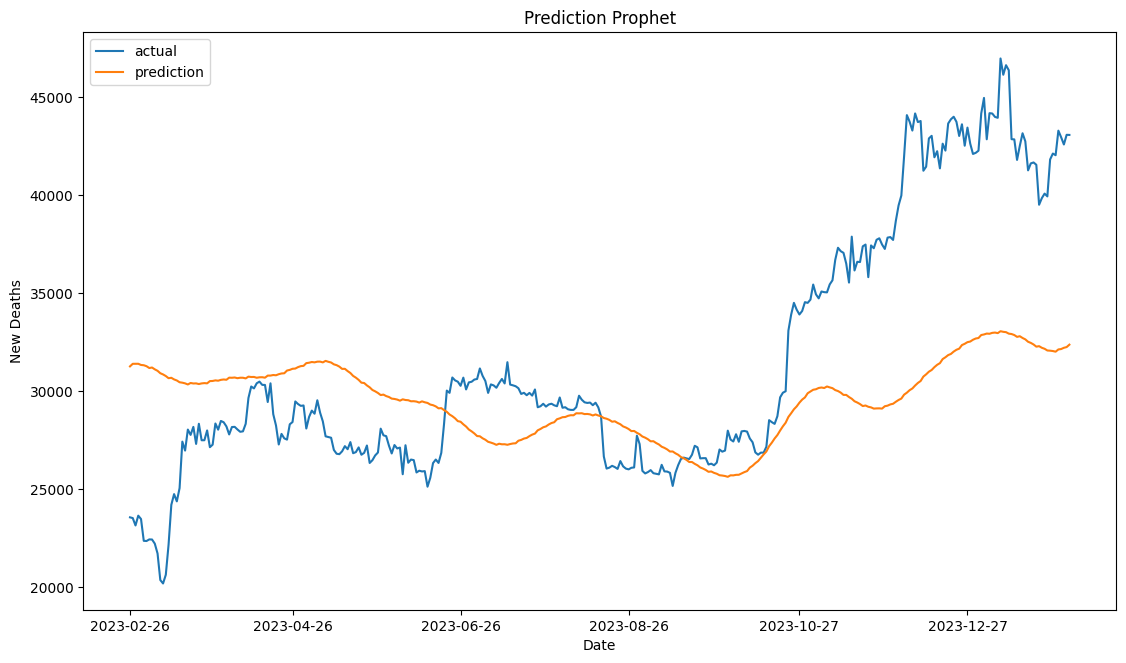

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()